## Check the whole feature maps not only last layer

How about simply modify the first layer or the layer that difference is getting bigger?

So check the whole layers' feature maps when the original image and perturbed image get into the model

In [40]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import os
import sys
import torchvision
sys.path.append('/workspace')
from PGD import PGD
from models import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  
    
cuda = True if torch.cuda.is_available() else False
print(cuda)

class Hook():
    def __init__(self, module, backward=False):
        self.hook = module.register_backward_hook(self.forwardhooking) if backward else module.register_forward_hook(self.forwardhooking)
    def forwardhooking(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 100

test_dataset = torchvision.datasets.CIFAR10(root='/workspace/my_data', train=False, download=False, transform=transform_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model = ResNet18() ## original model
checkpoint_path2 = '/workspace/checkpoint/resnet18_cifar10'
checkpoint2 = torch.load(checkpoint_path2)['net']
for key in list(checkpoint2.keys()):
    checkpoint2[key.replace('module.', '')] = checkpoint2.pop(key)
model.load_state_dict(checkpoint2, strict=False)## original model
model = model.cuda()
model.eval()

attack = PGD(model, cuda=cuda) # original model

cos = nn.CosineSimilarity(dim=2)
cos_lin = nn.CosineSimilarity(dim=1)

cos_sim = {}
for ori_imgs, ori_labels in test_loader:

    pgd_imgs = attack(ori_imgs, ori_labels)
    ori_imgs = ori_imgs.cuda()
    
    hookF = []
    for name, m in model.named_modules():
        if "conv" in name or "bn" in name or "linear" in name: # 17 layers for conv and bn each and there is one linear layer
            hookF.append(Hook(m, backward=False))
            if name not in cos_sim.keys():
                cos_sim[name] = 0
    
    model(ori_imgs) # The firt 35 layers are stored in holder
    ori_holder = [hook.output for hook in hookF]
    model(pgd_imgs) # The last 35 layers are stored in holder
    adv_holder = [hook.output for hook in hookF]
    for i in range(len(adv_holder)):
        if i != len(adv_holder)-1:
            cos_sim[list(cos_sim.keys())[i]] += cos(ori_holder[i][:,:,-1], adv_holder[i][:,:,-1]).mean().detach().cpu().item()
        else:
            cos_sim[list(cos_sim.keys())[i]] += cos_lin(ori_holder[i], adv_holder[i]).mean().detach().cpu().item()
    

for i in range(len(cos_sim)):
    cos_sim[list(cos_sim.keys())[i]] /= len(test_loader)

torch.cuda.empty_cache()

True


In [42]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import os
import sys
import torchvision
sys.path.append('/workspace')
from PGD import PGD
from models import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  
    
cuda = True if torch.cuda.is_available() else False
print(cuda)

class Hook():
    def __init__(self, module, backward=False):
        self.hook = module.register_backward_hook(self.forwardhooking) if backward else module.register_forward_hook(self.forwardhooking)
    def forwardhooking(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 100

test_dataset = torchvision.datasets.CIFAR10(root='/workspace/my_data', train=False, download=False, transform=transform_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model = ResNet18() ## original model
checkpoint_path2 = '/workspace/checkpoint/resnet18_pgd_adversarial_training'
checkpoint2 = torch.load(checkpoint_path2)['net']
for key in list(checkpoint2.keys()):
    checkpoint2[key.replace('module.', '')] = checkpoint2.pop(key)
model.load_state_dict(checkpoint2, strict=False)## original model
model = model.cuda()
model.eval()

attack = PGD(model, cuda=cuda) # original model

cos = nn.CosineSimilarity(dim=2)
cos_lin = nn.CosineSimilarity(dim=1)

adv_cos_sim = {}
for ori_imgs, ori_labels in test_loader:

    pgd_imgs = attack(ori_imgs, ori_labels)
    ori_imgs = ori_imgs.cuda()
    
    hookF = []
    for name, m in model.named_modules():
        if "conv" in name or "bn" in name or "linear" in name: # 17 layers for conv and bn each and there is one linear layer
            hookF.append(Hook(m, backward=False))
            if name not in adv_cos_sim.keys():
                adv_cos_sim[name] = 0
    
    model(ori_imgs) # The firt 35 layers are stored in holder
    ori_holder = [hook.output for hook in hookF]
    model(pgd_imgs) # The last 35 layers are stored in holder
    adv_holder = [hook.output for hook in hookF]
    for i in range(len(adv_holder)):
        if i != len(adv_holder)-1:
            adv_cos_sim[list(adv_cos_sim.keys())[i]] += cos(ori_holder[i][:,:,-1], adv_holder[i][:,:,-1]).mean().detach().cpu().item()
        else:
            adv_cos_sim[list(adv_cos_sim.keys())[i]] += cos_lin(ori_holder[i], adv_holder[i]).mean().detach().cpu().item()
    

for i in range(len(adv_cos_sim)):
    adv_cos_sim[list(adv_cos_sim.keys())[i]] /= len(test_loader)

torch.cuda.empty_cache()

True


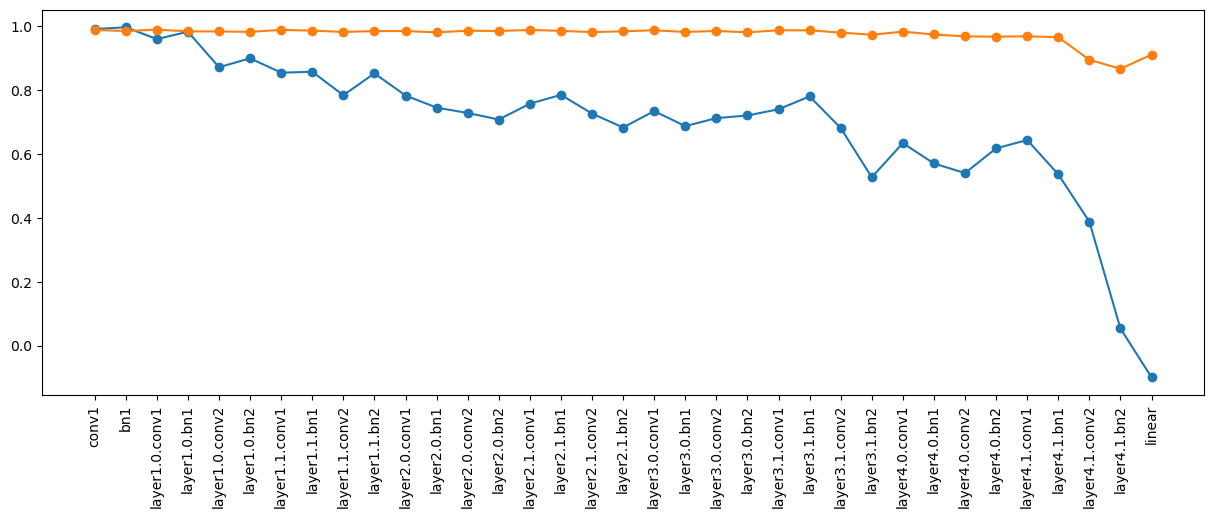

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(list(cos_sim.keys()),list(cos_sim.values()), marker='o', label='original')
plt.plot(list(adv_cos_sim.keys()),list(adv_cos_sim.values()), marker='o', label='adv')
plt.xticks(rotation=90)
plt.show()

## Conclusions & Considerations
- The difference between the original image and adversarial image is getting bigger as the layer goes deeper
- Especially the difference between the original image and adversarial image is getting bigger in the last layer
- layer1.conv2, layer3.conv2, layer3.bn2, layer4.conv2, layer4.bn2 make the big difference
- - Second layer of each block makes the big difference -> Has some meaning?
- - Did second layer of each block is sensitive to noise? -> Need to check the paper
- - Have to check the relationship with represenatation bottleneck paper

### Check the resnet50 model

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import os
import sys
import torchvision
sys.path.append('/workspace')
from PGD import PGD
from models import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  
    
cuda = True if torch.cuda.is_available() else False
print(cuda)

class Hook():
    def __init__(self, module, backward=False):
        self.hook = module.register_backward_hook(self.forwardhooking) if backward else module.register_forward_hook(self.forwardhooking)
    def forwardhooking(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 100

test_dataset = torchvision.datasets.CIFAR10(root='/workspace/my_data', train=False, download=False, transform=transform_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model = ResNet50() ## original model
checkpoint_path2 = '/workspace/checkpoint/resnet50_cifar10'
checkpoint2 = torch.load(checkpoint_path2)['net']
for key in list(checkpoint2.keys()):
    checkpoint2[key.replace('module.', '')] = checkpoint2.pop(key)
model.load_state_dict(checkpoint2, strict=False)## original model
model = model.cuda()
model.eval()

attack = PGD(model, cuda=cuda) # original model

cos = nn.CosineSimilarity(dim=2)
cos_lin = nn.CosineSimilarity(dim=1)

cos_sim = {}
for ori_imgs, ori_labels in test_loader:

    pgd_imgs = attack(ori_imgs, ori_labels)
    ori_imgs = ori_imgs.cuda()
    
    hookF = []
    for name, m in model.named_modules():
        if "conv" in name or "bn" in name or "linear" in name: # 17 layers for conv and bn each and there is one linear layer
            hookF.append(Hook(m, backward=False))
            if name not in cos_sim.keys():
                cos_sim[name] = 0
    
    model(ori_imgs) # The firt 35 layers are stored in holder
    ori_holder = [hook.output for hook in hookF]
    model(pgd_imgs) # The last 35 layers are stored in holder
    holder = [hook.output for hook in hookF]
    for i in range(len(holder)):
        if i != len(holder)-1:
            cos_sim[list(cos_sim.keys())[i]] += cos(ori_holder[i][:,:,-1], holder[i][:,:,-1]).mean().detach().cpu().item()
        else:
            cos_sim[list(cos_sim.keys())[i]] += cos_lin(ori_holder[i], holder[i]).mean().detach().cpu().item()
    

for i in range(len(cos_sim)):
    cos_sim[list(cos_sim.keys())[i]] /= len(test_loader)

torch.cuda.empty_cache()

True


In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import os
import sys
import torchvision
sys.path.append('/workspace')
from PGD import PGD
from models import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2"  
    
cuda = True if torch.cuda.is_available() else False
print(cuda)

class Hook():
    def __init__(self, module, backward=False):
        self.hook = module.register_backward_hook(self.forwardhooking) if backward else module.register_forward_hook(self.forwardhooking)
    def forwardhooking(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 100

test_dataset = torchvision.datasets.CIFAR10(root='/workspace/my_data', train=False, download=False, transform=transform_test)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model = ResNet50() ## original model
checkpoint_path2 = '/workspace/checkpoint/resnet50_pgd_adversarial_training'
checkpoint2 = torch.load(checkpoint_path2)['net']
for key in list(checkpoint2.keys()):
    checkpoint2[key.replace('module.', '')] = checkpoint2.pop(key)
model.load_state_dict(checkpoint2, strict=False)## original model
model = model.cuda()
model.eval()

attack = PGD(model, cuda=cuda) # original model

cos = nn.CosineSimilarity(dim=2)
cos_lin = nn.CosineSimilarity(dim=1)

adv_cos_sim = {}
for ori_imgs, ori_labels in test_loader:

    pgd_imgs = attack(ori_imgs, ori_labels)
    ori_imgs = ori_imgs.cuda()
    
    hookF = []
    for name, m in model.named_modules():
        if "conv" in name or "bn" in name or "linear" in name: # 17 layers for conv and bn each and there is one linear layer
            hookF.append(Hook(m, backward=False))
            if name not in adv_cos_sim.keys():
                adv_cos_sim[name] = 0
    
    model(ori_imgs) # The firt 35 layers are stored in holder
    adv_ori_holder = [hook.output for hook in hookF]
    model(pgd_imgs) # The last 35 layers are stored in holder
    holder = [hook.output for hook in hookF]
    for i in range(len(holder)):
        if i != len(holder)-1:
            adv_cos_sim[list(adv_cos_sim.keys())[i]] += cos(adv_ori_holder[i][:,:,-1], holder[i][:,:,-1]).mean().detach().cpu().item()
        else:
            adv_cos_sim[list(adv_cos_sim.keys())[i]] += cos_lin(adv_ori_holder[i], holder[i]).mean().detach().cpu().item()
    

for i in range(len(adv_cos_sim)):
    adv_cos_sim[list(adv_cos_sim.keys())[i]] /= len(test_loader)

torch.cuda.empty_cache()

True


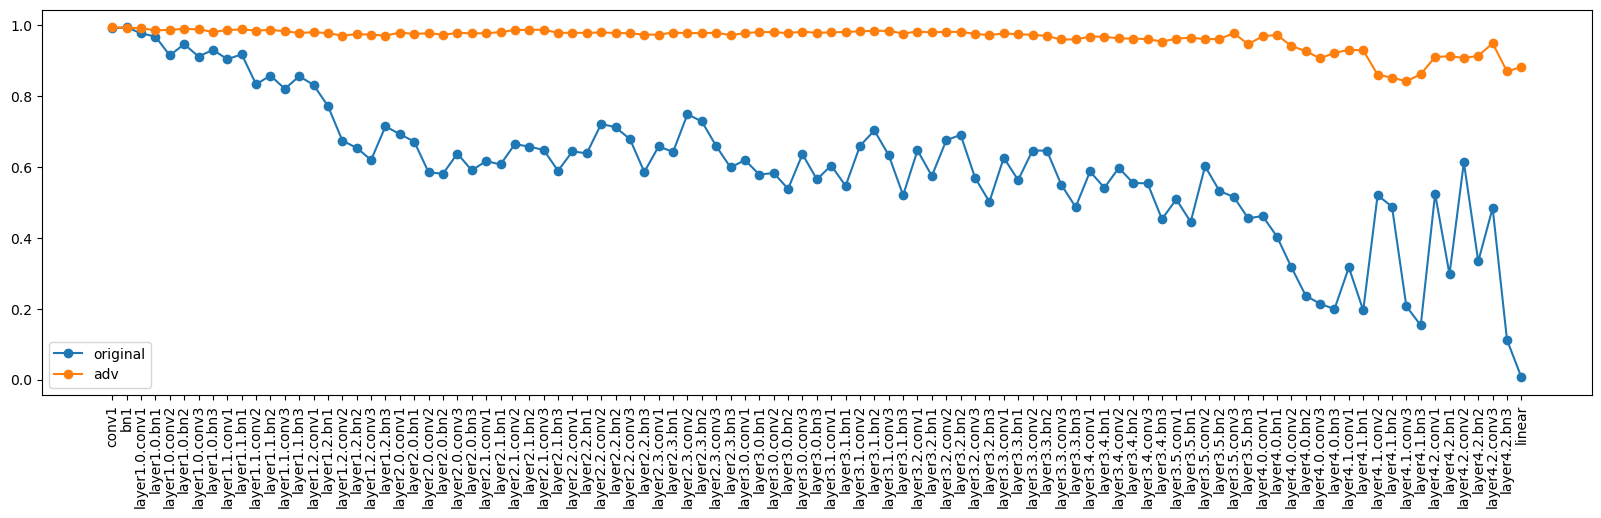

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(list(cos_sim.keys()),list(cos_sim.values()), marker='o', label='original')
plt.plot(list(adv_cos_sim.keys()),list(adv_cos_sim.values()), marker='o', label='adv')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [11]:
cos_sim

{'conv1': 0.9906690889596939,
 'bn1': 0.9937526065111161,
 'layer1.0.conv1': 0.9766582769155502,
 'layer1.0.bn1': 0.967491626739502,
 'layer1.0.conv2': 0.9143508785963058,
 'layer1.0.bn2': 0.9462835150957107,
 'layer1.0.conv3': 0.9111035442352295,
 'layer1.0.bn3': 0.9302914547920227,
 'layer1.1.conv1': 0.9036519283056259,
 'layer1.1.bn1': 0.917586760520935,
 'layer1.1.conv2': 0.8330205154418945,
 'layer1.1.bn2': 0.857643101811409,
 'layer1.1.conv3': 0.8199994528293609,
 'layer1.1.bn3': 0.8559346824884415,
 'layer1.2.conv1': 0.8310188376903533,
 'layer1.2.bn1': 0.7715020543336868,
 'layer1.2.conv2': 0.6742588549852371,
 'layer1.2.bn2': 0.6536597496271134,
 'layer1.2.conv3': 0.6197633308172226,
 'layer1.2.bn3': 0.7144913160800934,
 'layer2.0.conv1': 0.6922977328300476,
 'layer2.0.bn1': 0.6713827288150788,
 'layer2.0.conv2': 0.5846454906463623,
 'layer2.0.bn2': 0.5808224093914032,
 'layer2.0.conv3': 0.6374953573942185,
 'layer2.0.bn3': 0.5903514838218689,
 'layer2.1.conv1': 0.616623426079